In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft
from scipy.optimize import curve_fit
from matplotlib.colors import Normalize
from qutip import *
import random
from matplotlib.animation import FuncAnimation
import collections
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import time
import threading

In [2]:
"""qubitパラメータ"""

f_q = [7500, 8300]
f_anharm = [-380, -400]
f_g = -10


"""演算子の定義"""

N = 3 # 非調和3準位系を考える

a0 = tensor(destroy(N), qeye(N)) # Q1の消滅演算子
a1 = tensor(qeye(N), destroy(N)) # Q2の消滅演算子
a = [a0, a1]

P0_0 = tensor(basis(N,0) * basis(N,0).dag(), qeye(N)) # |0><0|
P1_0 = tensor(basis(N,1) * basis(N,1).dag(), qeye(N)) # |1><1|
Z_0 = P0_0 - P1_0 #sigma_z
X_0 = tensor(basis(N,0) * basis(N,1).dag() + basis(N,1) * basis(N,0).dag(), qeye(N)) #sigma_x
Y_0 = tensor(1j * basis(N,0) * basis(N,1).dag() - 1j * basis(N,1) * basis(N,0).dag(), qeye(N)) #sigma_y

P0_1 = tensor(qeye(N), basis(N,0) * basis(N,0).dag()) # |0><0|
P1_1 = tensor(qeye(N), basis(N,1) * basis(N,1).dag()) # |1><1|
Z_1 = P0_1 - P1_1 #sigma_z
X_1 = tensor(qeye(N), basis(N,0) * basis(N,1).dag() + basis(N,1) * basis(N,0).dag()) #sigma_x
Y_1 = tensor(qeye(N), 1j * basis(N,0) * basis(N,1).dag() - 1j * basis(N,1) * basis(N,0).dag()) #sigma_y

P0 = [P0_0, P0_1]
P1 = [P1_0, P1_1]
Z = [Z_0, Z_1]
X = [X_0, X_1]
Y = [Y_0, Y_1]


"""ハミルトニアン"""

# qubitの自由ハミルトニアン
H_q = []
for i in range(2):
    H_qi = 2*np.pi * f_q[i] * a[i].dag() * a[i] + (2*np.pi*f_anharm[i] / 2) * a[i].dag() * a[i].dag() * a[i] * a[i]
    H_q.append(H_qi)

# 駆動ハミルトニアンの時間無依存部分
H_d = []
for i in range(2):
    H_di = 2*np.pi * (a[i].dag() + a[i])
    H_d.append(H_di)

# 相互作用ハミルトニアン
H_int = 2*np.pi * f_g *(a[0] * a[1].dag() + a[0].dag() * a[1])

t_list = np.linspace(0, 0.2, 10001) # 時間リスト

# 全体のハミルトニアン
def H_tot(f_rabi, f_d, phi, t_list):
    H_tot = [H_q[0] + H_q[1] + H_int, 
             [H_d[0], np.real(f_rabi[0] * np.exp(1j * (2*np.pi * f_d[0] * t_list + phi[0])))], 
             [H_d[1], np.real(f_rabi[1] * np.exp(1j * (2*np.pi * f_d[1] * t_list + phi[1])))]
            ] 
    return H_tot


"""リンドブラッド演算子"""

gamma = [0.1, 0.1]
L_l = []
for i in range(2):
    L_li = np.sqrt(gamma[i]) * a[i] # 縦緩和
    L_l.append(L_li)

gamma_p = [0.3, 0.3]
L_p = []
for i in range(2):
    L_pi = np.sqrt(2*gamma_p[i]) * a[i].dag() * a[i] # 純位相緩和
    L_p.append(L_pi)


"""初期状態"""

ini_state = tensor(basis(N,0), basis(N,0))   #　|0>|0>

In [3]:
"""関数, クラスの定義"""


class StateEvo:
    """
    量子状態の時間発展を記述するクラス
    """

    def __init__(self, state, time=0):
        """
        コンストラクタ.
        インスタンスはstateとtimeの2つの内部変数を内蔵する.
        """
        self.state = state # 現在の量子状態
        self.time = time # 現在の時刻

    def rect_evlp(A, phi, t_list):
        """     
        Parameters
        ----------
        A : 駆動マイクロ波振幅
        phi : 駆動マイクロ波位相
        t_list : 時間リスト

        Returns
        -------
        t_listの長さの矩形パルスの包絡線の複素振幅波形リスト
        """
        func = np.array([A * np.exp(1j * phi) for i in t_list])
        return func
        
    def drag_evlp(A, R, phi, t_list):
        """
        Parameters
        ----------
        A : 最適化DRAG振幅
        R : 最適化DRAG IQ比
        phi : 駆動マイクロ波位相
        t_list : 時間リスト

        Returns
        -------
        t_listの長さのDrag1回分の包絡線の複素振幅リスト
        """
        t_total_length = t_list[-1] - t_list[0]
        t_list_from_zero = np.array(t_list) - t_list[0]
        func = A * (1 - np.cos(2*np.pi * t_list_from_zero / t_total_length) \
                    + 1j * R * np.sin(2*np.pi * t_list_from_zero / t_total_length)) \
                * np.exp(1j * phi)
        return func
    
    def cos_rise_evlp(A, phi, t_list):
        """     
        Parameters
        ----------
        A : 駆動マイクロ波振幅
        phi : 駆動マイクロ波位相
        t_list : 時間リスト

        Returns
        -------
        t_listの長さのcos_rise立ち上がりの包絡線の複素振幅波形リスト
        """
        t_total_length = t_list[-1] - t_list[0]
        t_list_from_zero = np.array(t_list) - t_list[0]

        func = A * (1 - np.cos(np.pi * t_list_from_zero / t_total_length)) / 2 * np.exp(1j * phi)
        
        return func
    
    def cos_fall_evlp(A, phi, t_list):
        """     
        Parameters
        ----------
        A : 駆動マイクロ波振幅
        phi : 駆動マイクロ波位相
        t_list : 時間リスト

        Returns
        -------
        t_listの長さのcos_rise立ち上がりの包絡線の複素振幅波形リスト
        """
        t_total_length = t_list[-1] - t_list[0]
        t_list_from_zero = np.array(t_list) - t_list[0]

        func = A * (1 - np.cos(np.pi * (t_list_from_zero-t_total_length) / t_total_length)) / 2 * np.exp(1j * phi)
        
        return func

    def raisedcos_evlp(A, phi, t_list):
        """     
        Parameters
        ----------
        A : 駆動マイクロ波振幅
        phi : 駆動マイクロ波位相
        t_list : 時間リスト

        Returns
        -------
        t_listの長さのレイズドコサイン・フラットトップパルスの包絡線の複素振幅波形リスト
        """
        t_rise = 0.02 # 立ち上がり・立ち下がり時間（決め打ち）

        func = (0 + 0j) * t_list #リストの初期化
        t_total_length = t_list[-1] - t_list[0]
        t_list_from_zero = np.array(t_list) - t_list[0]

        cdtn1 = (t_list_from_zero < t_rise)
        cdtn2 = (t_rise <= t_list_from_zero) & (t_list_from_zero < t_total_length - t_rise)
        cdtn3 = (t_total_length - t_rise <= t_list_from_zero) & (t_list_from_zero < t_total_length)

        func[cdtn1] = A * (1 - np.cos(np.pi * t_list_from_zero[cdtn1] / t_rise)) / 2 * np.exp(1j * phi)
        func[cdtn2] = A * np.exp(1j * phi)    
        func[cdtn3] = A * (1 - np.cos(np.pi * (t_list_from_zero[cdtn3] - t_total_length) / t_rise)) / 2 * np.exp(1j * phi)

        return func
    
    def create_drive_t_list(waveform_list, f_carrier, driven_qubit_num, t_list):
        """
        Parameters
        ----------
        waveform_list : 1つの包絡線の複素波形リスト
        f_carrier : 搬送波周波数
        driven_qubit_num : 駆動するqubitの番号
        t_list : waveform_listに対応する時間リスト

        Returns
        -------
        2×1行列のリストにおいて, driven_qubit_numで選んだ行以外は0要素のリスト, 
        driven_qubit_numで選んだ行は, waveform_listに搬送波をかけた複素波形が乗ったリスト
        """
        drive_t_list = np.array(t_list) * np.array([[0 + 0j], [0 + 0j]]) # 初期化
        drive_t_list[driven_qubit_num] = waveform_list * np.exp(1j * 2*np.pi * f_carrier * t_list)

        return drive_t_list  
    
    
    def state_evo(drive_t_list, state, t_list):
        """
        状態とハミルトニアンを入力すると, 時間発展後の状態と時刻を返す関数.
        drive_t_list : 駆動マイクロ波複素振幅に対応する時間リストの, qubit毎のリスト. 
        state  : 時間発展前の状態
        time   : 現在時刻
        t_list : この時間発展の時間リスト
        """
        H_drive = [H_q[0] + H_q[1] + H_int, 
                   [H_d[0], np.real(drive_t_list[0])], 
                   [H_d[1], np.real(drive_t_list[1])]
                  ] 
        result = mesolve(H_drive, state, t_list, L_l + L_p, [])

        return result.states[-1]
    
        
    def rect(self, qubit_num, drive_freq, ampl, phase, duration):
        """1qubitの矩形波での時間発展"""
        
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + duration, int(duration/1e-5 + 1))
        # 矩形波の包絡線リスト
        waveform_evlp = StateEvo.rect_evlp(ampl, phase, t_list)
        # 搬送波を含めたraisedcosの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp, drive_freq, qubit_num, t_list) 
        
        self.state = StateEvo.state_evo(drive_t_list, self.state, t_list)
        self.time += duration
        
    def rect2(self, drive_freq_list, ampl_list, phase_list, duration):
        """2qubit同時の矩形波での時間発展"""
        
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + duration, int(duration/1e-5 + 1))
        # 矩形波の包絡線リスト
        waveform_evlp0 = StateEvo.rect_evlp(ampl_list[0], phase_list[0], t_list)
        waveform_evlp1 = StateEvo.rect_evlp(ampl_list[1], phase_list[1], t_list)
        # 搬送波を含めたrectの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp0, drive_freq_list[0], 0, t_list) \
                       + StateEvo.create_drive_t_list(waveform_evlp1, drive_freq_list[1], 1, t_list)
        
        self.state = StateEvo.state_evo(drive_t_list, self.state, t_list)
        self.time += duration
        
    def drag_for_calib(self, ampl, iq_ratio, qubit_num, phase):
        """校正前のDRAG-hpiの時間発展（ampl, iq_ratioを調整できる）"""
        
        # DRAGパルス時間長（固定）
        t_drag_hpi = 0.021 
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + t_drag_hpi, 3001)
        # DRAGの包絡線リスト
        waveform_evlp = StateEvo.drag_evlp(ampl, iq_ratio, phase, t_list) 
        # 搬送波を含めたDRAGの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp, f_q2[qubit_num], qubit_num, t_list) 
        
        self.state = StateEvo.state_evo(drive_t_list, self.state, t_list)
        self.time += t_drag_hpi
        
    def drag(self, qubit_num, phase):
        """DRAG-hpiの時間発展"""
        
        # DRAGパルス時間長（固定）
        t_drag_hpi = 0.021 
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + t_drag_hpi, 3001)
        # DRAGの包絡線リスト
        waveform_evlp = StateEvo.drag_evlp(ampl_opt_list[qubit_num], iq_ratio_opt_list[qubit_num], phase, t_list) 
        # 搬送波を含めたDRAGの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp, f_q2[qubit_num], qubit_num, t_list) 
        
        self.state = StateEvo.state_evo(drive_t_list, self.state, t_list)
        self.time += t_drag_hpi
    
    def cos_rise(self, qubit_num, drive_freq, ampl, phase):
        """cos型での立ち上がりの時間発展"""
        
        # 立ち上がり時間長（固定）
        t_rise = 0.02 
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + t_rise, 3001)
        # cos_riseの包絡線リスト
        waveform_evlp = StateEvo.cos_rise_evlp(ampl, phase, t_list) 
        # 搬送波を含めたcos_riseの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp, drive_freq, qubit_num, t_list)
        
        self.state = StateEvo.state_evo(drive_t_list, self.state, t_list)
        self.time += t_rise
        
    def cos_rise2(self, drive_freq_list, ampl_list, phase_list):
        """cos型での立ち上がりの時間発展"""
        
        # 立ち上がり時間長（固定）
        t_rise = 0.02 
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + t_rise, 3001)
        # 矩形波の包絡線リスト
        waveform_evlp0 = StateEvo.cos_rise_evlp(ampl_list[0], phase_list[0], t_list)
        waveform_evlp1 = StateEvo.cos_rise_evlp(ampl_list[1], phase_list[1], t_list)
        # 搬送波を含めたraisedcosの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp0, drive_freq_list[0], 0, t_list) \
                       + StateEvo.create_drive_t_list(waveform_evlp1, drive_freq_list[1], 1, t_list)
        
        self.state = StateEvo.state_evo(drive_t_list, self.state, t_list)
        self.time += t_rise
        
    def cos_fall(self, qubit_num, drive_freq, ampl, phase):
        """cos型での立ち下がりの時間発展"""
        
        # 立ち下がり時間長（固定）
        t_fall = 0.02 
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + t_fall, 3001)
        # cos_riseの包絡線リスト
        waveform_evlp = StateEvo.cos_fall_evlp(ampl, phase, t_list) 
        # 搬送波を含めたcos_riseの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp, drive_freq, qubit_num, t_list)
        
        self.state = StateEvo.state_evo(drive_t_list, self.state, t_list)
        self.time += t_fall
        
    def cos_fall2(self, drive_freq_list, ampl_list, phase_list):
        """cos型での立ち下がりの時間発展"""
        
        # 立ち上がり時間長（固定）
        t_fall = 0.02 
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + t_fall, 3001)
        # 矩形波の包絡線リスト
        waveform_evlp0 = StateEvo.cos_fall_evlp(ampl_list[0], phase_list[0], t_list)
        waveform_evlp1 = StateEvo.cos_fall_evlp(ampl_list[1], phase_list[1], t_list)
        # 搬送波を含めたraisedcosの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp0, drive_freq_list[0], 0, t_list) \
                       + StateEvo.create_drive_t_list(waveform_evlp1, drive_freq_list[1], 1, t_list)
        
        self.state = StateEvo.state_evo(drive_t_list, self.state, t_list)
        self.time += t_fall
    
    def rc_ft(self, qubit_num, drive_freq, ampl, phase, duration):
        """raised cosine flat topの時間発展"""
        
        # 立ち上がり時間長（固定）
        t_rise = 0.02
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + duration + 2*t_rise, int((duration+ 2*t_rise)/1e-5 + 1))
        # raisedcosの包絡線リスト
        waveform_evlp = StateEvo.raisedcos_evlp(ampl, phase, t_list)
        # 搬送波を含めたraisedcosの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp, drive_freq, qubit_num, t_list) 
        
        self.state = StateEvo.state_evo(drive_t_list, self.state, t_list)
        self.time += duration
        
    def rc_ft2(self, drive_freq_list, ampl_list, phase_list, duration):
        """raised cosine flat topの時間発展"""
        
        # 立ち上がり時間長（固定）
        t_rise = 0.02
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + duration + 2*t_rise, int((duration+ 2*t_rise)/1e-5 + 1))
        # 矩形波の包絡線リスト
        waveform_evlp0 = StateEvo.raisedcos_evlp(ampl_list[0], phase_list[0], t_list)
        waveform_evlp1 = StateEvo.raisedcos_evlp(ampl_list[1], phase_list[1], t_list)
        # 搬送波を含めたraisedcosの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp0, drive_freq_list[0], 0, t_list) \
                       + StateEvo.create_drive_t_list(waveform_evlp1, drive_freq_list[1], 1, t_list)
        
        self.state = StateEvo.state_evo(drive_t_list, self.state, t_list)
        self.time += duration
        
    def meas_Z(self, qubit_num):
        """Z期待値の計算"""
        return expect(Z[qubit_num], self.state)
    
    def meas_X(self, qubit_num):
        """X期待値の計算"""
        
        # DRAGパルス時間長（固定）
        t_drag_hpi = 0.021 
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + t_drag_hpi, 3001)
        # DRAGの包絡線リスト
        waveform_evlp = StateEvo.drag_evlp(ampl_opt_list[qubit_num], iq_ratio_opt_list[qubit_num], -np.pi/2, t_list) 
        # 搬送波を含めたDRAGの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp, f_q2[qubit_num], qubit_num, t_list) 
        # X測定のために状態をY-hpi回転
        state_X_meas = StateEvo.state_evo(drive_t_list, self.state, t_list)
        
        return expect(Z[qubit_num], state_X_meas)
    
    def meas_Y(self, qubit_num):
        """Y期待値の計算"""
        
        # DRAGパルス時間長（固定）
        t_drag_hpi = 0.021 
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + t_drag_hpi, 3001)
        # DRAGの包絡線リスト
        waveform_evlp = StateEvo.drag_evlp(ampl_opt_list[qubit_num], iq_ratio_opt_list[qubit_num], -np.pi, t_list) 
        # 搬送波を含めたDRAGの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp, f_q2[qubit_num], qubit_num, t_list) 
        # Y測定のために状態をX-hpi回転
        state_Y_meas = StateEvo.state_evo(drive_t_list, self.state, t_list)
        
        return expect(Z[qubit_num], state_Y_meas)

    
from qutip import Bloch
def draw_bloch(XYZ_list_g, XYZ_list_e):
    """
    Bloch球にリストデータを表示. 
    """
    view_list = [[0,0], [90,0], [0,90], [30,30]]
    
    for i in range(4):
        
        b = Bloch()
        
        points_g = [XYZ_list_g[0], XYZ_list_g[1], XYZ_list_g[2]]
        points_e = [XYZ_list_e[0], XYZ_list_e[1], XYZ_list_e[2]]
        start_g = [XYZ_list_g[0][0], XYZ_list_g[1][0], XYZ_list_g[2][0]]
        start_e = [XYZ_list_e[0][0], XYZ_list_e[1][0], XYZ_list_e[2][0]]
        
        b.add_points(points_g)
        b.add_points(points_e)
        b.add_points(start_g)
        b.add_points(start_e)

        b.point_color = ['r', 'b', 'm', 'c']
        b.point_size = [20, 20, 200, 200]
    
        b.view = view_list[i]
        b.show()    

In [ ]:
#histogram update value

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import time
%matplotlib widget

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

psi = (ini_state.dag()[0][0]).real
psi_upd = []

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Fixing random state for reproducibility
hist = psi
xedges = range(3)
yedges = range(3)

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges , yedges, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = np.array(hist)

cmap = cm.get_cmap('jet') # Get desired colormap
max_height = 1.0   # get range of colorbars
min_height = 0.0

# scale each z to [0,1], and get their rgb values
rgba = [cmap(k) for k in dz] 

ax.bar3d(xpos, ypos, zpos, dx, dy, dz,color=rgba) 
plt.xticks(xpos, ["0","0","0","1","1","1","2","2","2"])
plt.yticks(ypos, ["0","1","2","0","1","2","0","1","2"])
    
def update(i):
    global atime, psi_upd
    if len(psi_upd)>0:
        ax.clear()
        dz = psi_upd[0]
        cmap = cm.get_cmap('jet')
        
        rgba = [cmap(k) for k in dz] 
        ax.bar3d(xpos, ypos, zpos, dx, dy, dz,color=rgba) 
        ax.set_zlim(0,1.0)
        plt.xticks(xpos, ["0","0","0","1","1","1","2","2","2"])
        plt.yticks(ypos, ["0","1","2","0","1","2","0","1","2"])
        
        psi_upd = psi_upd[1:]
        time.sleep(0.4)
        

anim = FuncAnimation(fig, update, interval=100, blit=True)
   
plt.show()

In [ ]:
f_rabi = [20, 20] # 振幅
f_d = [0, 0] # 周波数
f_d[0] = f_q[0]
f_d[1] = f_q[1]
# f_d = f_q # 周波数
phi = [0, 0] # 位相
#dt = 0.002 # 時間間隔

#print(StateEvo(ini_state,0).rect(0, f_d[0], f_rabi[0], phi[0], dt))

In [ ]:
#duration = 0.5*dt
dt = 0.00004
duration = 0.04
t_list = np.linspace(0, 0 + duration, round(duration/dt)+1)
#t_list = np.linspace(0, 0 + 0.04, 1001)
#print(int(duration/1e-5 + 1))
drive_t_list = np.array(t_list) * np.array([[0 + 0j], [0 + 0j]]) # 初期化
A = f_rabi[0]
f_carrier = f_d[0]
driven_qubit_num = 0
state = ini_state
waveform_list = np.array([A * np.exp(1j * phi[0]) for i in t_list])
drive_t_list[driven_qubit_num] = waveform_list * np.exp(1j * 2*np.pi * f_carrier * t_list)    
H_drive = [H_q[0] + H_q[1] + H_int, 
                   [H_d[0], np.real(drive_t_list[0])], 
                   [H_d[1], np.real(drive_t_list[1])]
                  ] 
result = mesolve(H_drive, state, t_list, L_l + L_p, [])
#print(result.states[300][0][0])
#print(expect(Z[0], result.states[-1]))
def diag_values(psi):
    array = []
    for i in range(len(psi[0][0])):
        array.append((psi[i][0][i]).real)
    return array

for i in range(50):
    psi_upd.append(diag_values(result.states[20*i]))

C:\Users\nilton\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self.figure.savefig(buf, format='png', dpi='figure')


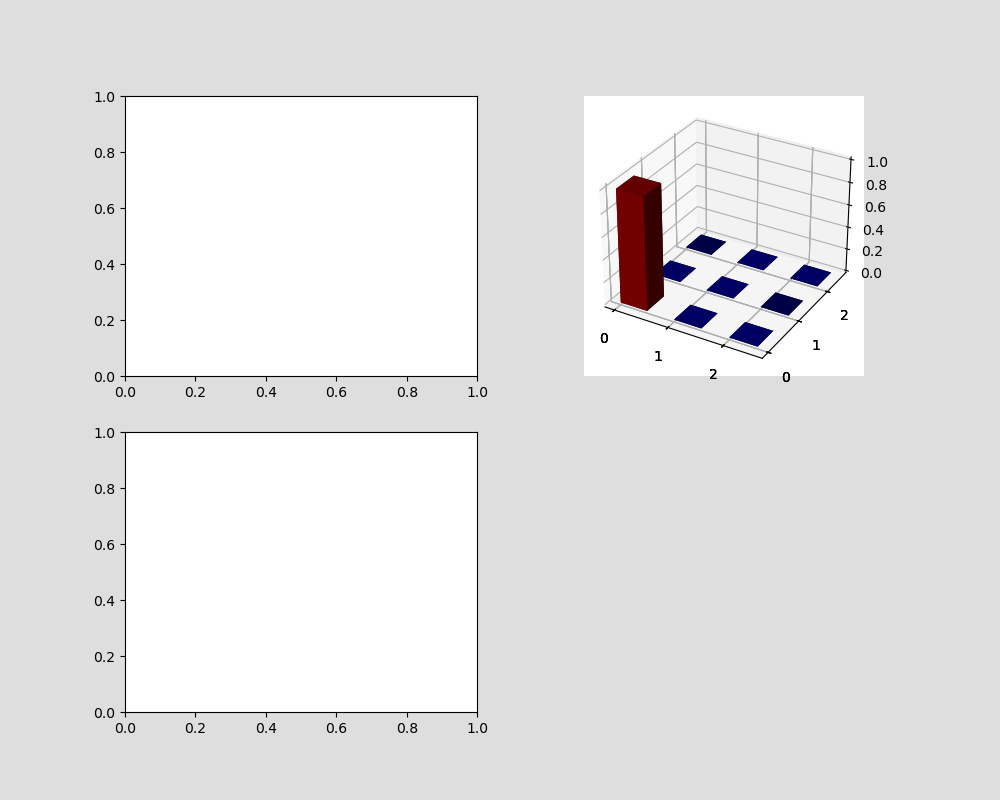

In [4]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import time
%matplotlib widget

# function to update the data
qstates = []
qsave = (0, 0, 0)
count = 0
#fig = plt.figure()
fig = plt.figure(figsize=(10,8), facecolor='#DEDEDE', tight_layout=True)

# define and adjust figure
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0,0], facecolor="white") 
ax2 = fig.add_subplot(gs[1,0], facecolor="white")  
ax3 = fig.add_subplot(gs[0:1, 1:2], projection='3d')  

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

psi = (ini_state.dag()[0][0]).real
psi_upd = []

# Fixing random state for reproducibility
hist = psi
xedges = range(3)
yedges = range(3)

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges , yedges, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = np.array(hist)

cmap = cm.get_cmap('jet') # Get desired colormap
max_height = 1.0   # get range of colorbars
min_height = 0.0

# scale each z to [0,1], and get their rgb values
rgba = [cmap(k) for k in dz] 

ax3.bar3d(xpos, ypos, zpos, dx, dy, dz,color=rgba) 
plt.xticks(xpos, ["0","0","0","1","1","1","2","2","2"])
plt.yticks(ypos, ["0","1","2","0","1","2","0","1","2"])


def my_function(i):
    # input control
    global qstates, count, qsave
    
    ctrl_input_q0_i.popleft()
    ctrl_input_q0_q.popleft()
    
    ctrl_input_q1_i.popleft()
    ctrl_input_q1_q.popleft()
    
    if len(qstates)>=1:
        ctrl_input_q0_i.append(qstates[0][0])
        ctrl_input_q0_q.append(qstates[0][1])
        
        ctrl_input_q1_i.append(qstates[0][2])
        ctrl_input_q1_q.append(qstates[0][3])
        
        '''q0_state0.append(qstates[0][2])
        q0_state1.append(qstates[0][3])
        q0_state2.append(qstates[0][4])'''
        
        #qsave = (qstates[0][2], qstates[0][3], qstates[0][4])
        qstates = qstates[1:]
    else:
        ctrl_input_q0_i.append(0)
        ctrl_input_q0_q.append(0)
        
        ctrl_input_q1_i.append(0)
        ctrl_input_q1_q.append(0)
    
   
    count += 1
    alist = np.arange(0+count,100+count,1)
    time.sleep(0.015)
        
    # clear axis
    ax1.cla()
    ax2.cla()
    
    ax1.set_title("Input Control Q0")
    ax2.set_title("Input Control Q1")
 
    # plot input1    
    ax1.set_ylim(-60,60)
    ax1.plot(alist/10, ctrl_input_q0_i,color="blue", label="I")
    ax1.scatter(alist[-1]/10, ctrl_input_q0_i[-1],color="blue")
    
    ax1.plot(alist/10, ctrl_input_q0_q,color="red", label="Q")
    ax1.scatter(alist[-1]/10, ctrl_input_q0_q[-1],color="red")
    
    ax1.set_xlabel("time[ns]", {"fontsize":15})
    ax1.set_ylabel("power[?]", {"fontsize":15})
    
    ax1.legend(loc=(0.05, 0.05))
    
    # plot input2
    #ax2.set_ylim(-1,1)
    ax2.set_ylim(-60,60)
    ax2.plot(alist/10, ctrl_input_q1_i,color="blue", label="I")
    ax2.scatter(alist[-1]/10, ctrl_input_q1_i[-1],color="blue")
    
    ax2.plot(alist/10, ctrl_input_q1_q,color="red", label="Q")
    ax2.scatter(alist[-1]/10, ctrl_input_q1_q[-1],color="red")
    
    ax2.set_xlabel("time[ns]", {"fontsize":15})
    ax2.set_ylabel("power[?]", {"fontsize":15})
    
    ax2.legend(loc=(0.05, 0.05))
    
    global atime, psi_upd
    if len(psi_upd)>0:
        ax3.clear()
        dz = psi_upd[0]
        cmap = cm.get_cmap('jet')
        
        rgba = [cmap(k) for k in dz] 
        ax3.bar3d(xpos, ypos, zpos, dx, dy, dz,color=rgba) 
        ax3.set_zlim(0,1.0)
        plt.xticks(xpos, ["0","0","0","1","1","1","2","2","2"])
        plt.yticks(ypos, ["0","1","2","0","1","2","0","1","2"])
        
        psi_upd = psi_upd[1:]
        #time.sleep(0.4)

# start collections with zeros
ctrl_input_q0_i = collections.deque(np.zeros(100))
ctrl_input_q0_q = collections.deque(np.zeros(100))
ctrl_input_q1_i = collections.deque(np.zeros(100))
ctrl_input_q1_q = collections.deque(np.zeros(100))

# animate

ani = FuncAnimation(fig, my_function, interval=50)
plt.show()

In [6]:
f_rabi = [20, 20] # 振幅
f_d = [0, 0] # 周波数
f_d[0] = f_q[0]
f_d[1] = f_q[1]
# f_d = f_q # 周波数
phi = [0, 0] # 位相

#duration = 0.5*dt
dt = 0.00004
duration = 0.04
t_list = np.linspace(0, 0 + duration, round(duration/dt)+1)
#t_list = np.linspace(0, 0 + 0.04, 1001)
#print(int(duration/1e-5 + 1))
drive_t_list = np.array(t_list) * np.array([[0 + 0j], [0 + 0j]]) # 初期化
A = f_rabi[0]
f_carrier = f_d[0]
driven_qubit_num = 0
state = ini_state
waveform_list = np.array([A * np.exp(1j * phi[0]) for i in t_list])
drive_t_list[driven_qubit_num] = waveform_list * np.exp(1j * 2*np.pi * f_carrier * t_list)    
H_drive = [H_q[0] + H_q[1] + H_int, 
                   [H_d[0], np.real(drive_t_list[0])], 
                   [H_d[1], np.real(drive_t_list[1])]
                  ] 
result = mesolve(H_drive, state, t_list, L_l + L_p, [])
#print(result.states[300][0][0])
#print(expect(Z[0], result.states[-1]))

def diag_values(psi):
    array = []
    for i in range(len(psi[0][0])):
        array.append((psi[i][0][i]).real)
    return array

In [7]:
# R(X/Y) gate
#ts = 0
#f_rabi = 50
#f_d = 7500
#phi = 0
result = mesolve(H_drive, state, t_list, L_l + L_p, [])
samples = 50
ts_f = duration
I = [1,0]
Q = [0,0]
for i in range(samples+1):
    psi_upd.append(diag_values(result.states[20*i]))
    qstates.append([f_rabi[0]*(I[0]*np.sin(2*np.pi*i*f_d[0]*(ts_f/(samples*10)) + phi[0])),f_rabi[0]*(Q[0]*np.cos(2*np.pi*i*f_d[0]*(ts_f/samples) + phi[0])), f_rabi[1]*(I[1]*np.sin(2*np.pi*i*f_d[1]*(ts_f/samples) + phi[1])),f_rabi[1]*(Q[1]*np.cos(2*np.pi*i*f_d[1]*(ts_f/samples) + phi[1]))]) 

In [ ]:
f_rabi = [20, 20] # 振幅
f_d = [0, 0] # 周波数
f_d[0] = f_q[0]
f_d[1] = f_q[1]
# f_d = f_q # 周波数
phi = [0, 0] # 位相

In [ ]:
state = diag_values(result.states[-1])
print(mesolve(H_drive, state, t_list, L_l + L_p, []))

In [ ]:
(diag_values(result.states[-1])*i_state)[1][1][0][0]

In [ ]:
tensor(basis(N,0), basis(N,0))-tensor(basis(N,0), basis(N,0))

In [ ]:
i_state = tensor(basis(N,0), basis(N,0))-tensor(basis(N,0), basis(N,0))
for i in range(3):
    for j in range(3):
        i_state += tensor(basis(N,i), basis(N,j))
print(i_state)

In [ ]:
ini = 0
state = ini_state
s_input = []
def input_manager():
    global ts, s_input, qstates, ini,state
    while(1):
        ts+=5
        time.sleep(0.001)
        if (ts%10 == 0):
            if(len(s_input)>100):
                t_list = np.linspace(s_input[0][0], s_input[100][0], 100+1)
                w = np.zeros(len(t_list), dtype=np.float32)
                for x in range(len(t_list)):
                    w[x] = s_input[x][1]+s_input[x][2]
                result = sesolve(H_tot(w), state, t_list)
                for i in range(100):
                    qstates.append([s_input[i][1],s_input[i][2],result.states[i][0][0][0]*result.states[i].dag()[0][0][0]\
                                    ,result.states[i][1][0][0]*result.states[i].dag()[0][0][1]\
                                    ,result.states[i][2][0][0]*result.states[i].dag()[0][0][2]])
                s_input = s_input[100:]
                state = result.states[-1]
                
            elif(len(s_input)>10):
                t_list = np.linspace(s_input[0][0], s_input[10][0], 10+1)
                w = np.zeros(len(t_list), dtype=np.float32)
                for x in range(len(t_list)-1):
                    w[x] = s_input[x][1]+s_input[x][2]
                result = sesolve(H_tot(w), state, t_list)
                for i in range(10):
                    qstates.append([s_input[i][1],s_input[i][2],result.states[i][0][0][0]*result.states[i].dag()[0][0][0]\
                                    ,result.states[i][1][0][0]*result.states[i].dag()[0][0][1]\
                                    ,result.states[i][2][0][0]*result.states[i].dag()[0][0][2]])
                s_input = s_input[10:]
                state = result.states[-1]
                
            elif(len(s_input)>1):
                t_list = np.linspace(s_input[0][0], s_input[1][0],  1+1)
                w = np.zeros(len(t_list), dtype=np.float32)
                for x in range(len(t_list)-1):
                    w[x] = s_input[x][1]+s_input[x][2]
                result = sesolve(H_tot(w), state, t_list)
                qstates.append([s_input[0][1],s_input[0][2],result.states[0][0][0][0]*result.states[0].dag()[0][0][0]\
                                ,result.states[0][1][0][0]*result.states[0].dag()[0][0][1]\
                                ,result.states[0][2][0][0]*result.states[0].dag()[0][0][2]])
                s_input = s_input[1:]
                state = result.states[-1]
                
            elif(len(s_input)==1):
                t_list = np.linspace(s_input[0][0]-3.3333333333333335e-05,s_input[0][0],  1+1)
                w = np.zeros(len(t_list), dtype=np.float32)
                for x in range(len(t_list)-1):
                    w[x] = s_input[x][1]+s_input[x][2]
                result = sesolve(H_tot(w), state, t_list)
                qstates.append([s_input[0][1],s_input[0][2],result.states[0][0][0][0]*result.states[0].dag()[0][0][0]\
                                ,result.states[0][1][0][0]*result.states[0].dag()[0][0][1]\
                                ,result.states[0][2][0][0]*result.states[0].dag()[0][0][2]])
                s_input = s_input[1:]
                state = result.states[-1]
            
            if(ini==1):
                ini=0
                state = ini_state
                qstates.append([0,0,state[0][0][0]*state.dag()[0][0][0]\
                    ,state[1][0][0]*state.dag()[0][0][1]\
                    ,state[2][0][0]*state.dag()[0][0][2]])

def initialize():
    global ini
    ini = 1

In [ ]:
#histogram update value

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import time
%matplotlib widget

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Fixing random state for reproducibility
hist = psi
xedges = range(3)
yedges = range(3)

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges , yedges, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = np.array(hist)

cmap = cm.get_cmap('jet') # Get desired colormap
max_height = 1.0   # get range of colorbars
min_height = 0.0

# scale each z to [0,1], and get their rgb values
rgba = [cmap(k) for k in dz] 

ax.bar3d(xpos, ypos, zpos, dx, dy, dz,color=rgba) 
plt.xticks(xpos, ["0","0","0","1","1","1","2","2","2"])
plt.yticks(ypos, ["0","1","2","0","1","2","0","1","2"])
    
def update(i):
    global atime, psi_upd
    if len(psi_upd)>0:
        ax.clear()
        dz = psi_upd[0]
        cmap = cm.get_cmap('jet')
        
        rgba = [cmap(k) for k in dz] 
        ax.bar3d(xpos, ypos, zpos, dx, dy, dz,color=rgba)  
        plt.xticks(xpos, ["0","0","0","1","1","1","2","2","2"])
        plt.yticks(ypos, ["0","1","2","0","1","2","0","1","2"])
        
        psi_upd = psi_upd[1:]
        time.sleep(0.5)
        

anim = FuncAnimation(fig, update, interval=500, blit=True)
   
plt.show()

In [ ]:
psi = np.array([0,0,0,0,0,0,0,0,0])
for i in range(9):
    psi[i] = ini_state[i][0][0]*ini_state.dag()[0][0][i]
print(psi)

In [ ]:
psi

In [ ]:
ini_state[0][0][0]*ini_state.dag()[0][0][0]

In [ ]:
"""Q0のみ駆動"""

"""時間発展, 測定"""

# 駆動マイクロ波のパラメータ
f_rabi = [20, 20] # 振幅
f_d = [0, 0] # 周波数
f_d[0] = f_q[0]
f_d[1] = f_q[1]
# f_d = f_q # 周波数
phi = [0, 0] # 位相

# 掃引時間
t_start = 0
t_end = 0.1
dt = 0.002 # 時間間隔
t_num = int((t_end - t_start) / dt) # 掃引点数
t_list = np.linspace(t_start, t_end, t_num+1)

state_time = StateEvo(ini_state, 0) # 現在の量子状態と時刻を表すオブジェクト

Z0_list = []
Z1_list = []

for t in t_list:
    
    if t!=0:
        state_time.rect(0, f_d[0], f_rabi[0], phi[0], dt)

    Z0_exp = state_time.meas_Z(qubit_num=0)
    Z0_list.append(Z0_exp)
    
    Z1_exp = state_time.meas_Z(qubit_num=1)
    Z1_list.append(Z1_exp)
    
    print(round(t, 3), flush=True)


"""測定結果のグラフ描画"""

fig, ax = plt.subplots(1, 1, figsize=(10,6))

ax.plot(t_list, Z0_list, label="Z0")
ax.plot(t_list, Z1_list, label="Z1")

ax.legend()
ax.set_xlabel('Time / us')
ax.set_ylabel('Expectation value')

In [ ]:
state_time = StateEvo(ini_state, 0)
state_time.rect(0, f_d[0], f_rabi[0], phi[0], 0.05*dt)
print(state_time.meas_Z(qubit_num=1))

In [ ]:
expect(Z[0], result.states[200:500])

In [ ]:
state_time.meas_Z(qubit_num=0)

In [ ]:
#duration = 0.5*dt
dt = 0.00004
duration = 0.04
t_list = np.linspace(0, 0 + duration, round(duration/dt)+1)
#t_list = np.linspace(0, 0 + 0.04, 1001)
#print(int(duration/1e-5 + 1))
drive_t_list = np.array(t_list) * np.array([[0 + 0j], [0 + 0j]]) # 初期化
A = f_rabi[0]
f_carrier = f_d[0]
driven_qubit_num = 0
state = ini_state
waveform_list = np.array([A * np.exp(1j * phi[0]) for i in t_list])
drive_t_list[driven_qubit_num] = waveform_list * np.exp(1j * 2*np.pi * f_carrier * t_list)    
H_drive = [H_q[0] + H_q[1] + H_int, 
                   [H_d[0], np.real(drive_t_list[0])], 
                   [H_d[1], np.real(drive_t_list[1])]
                  ] 
result = mesolve(H_drive, state, t_list, L_l + L_p, [])
#print(result.states[300][0][0])
#print(expect(Z[0], result.states[-1]))
def diag_values(psi):
    array = []
    for i in range(len(psi[0][0])):
        array.append((psi[i][0][i]).real)
    return array

for i in range(50):
    psi_upd.append(diag_values(result.states[20*i]))

In [ ]:
def diag_values(psi):
    array = []
    for i in range(len(psi[0][0])):
        array.append((psi[i][0][i]).real)
    return array

for i in range(50):
    psi_upd.append(diag_values(result.states[20*i]))

In [ ]:
round(0.04/0.00004)

In [ ]:
(result.states[i].dag()[0][0]*result.states[i][0][0])

In [ ]:
result.states[i]

In [ ]:
diag_values(result.states[1])

In [ ]:
ini_state[0][0]*ini_state.dag()[0][0]

In [ ]:
#histogram update value

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import time
%matplotlib widget

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

psi = (ini_state[0][0]*ini_state.dag()[0][0]).real
psi_upd = []

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Fixing random state for reproducibility
hist = psi
xedges = range(3)
yedges = range(3)

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges , yedges, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = np.array(hist)

cmap = cm.get_cmap('jet') # Get desired colormap
max_height = 1.0   # get range of colorbars
min_height = 0.0

# scale each z to [0,1], and get their rgb values
rgba = [cmap(k) for k in dz] 

ax.bar3d(xpos, ypos, zpos, dx, dy, dz,color=rgba) 
plt.xticks(xpos, ["0","0","0","1","1","1","2","2","2"])
plt.yticks(ypos, ["0","1","2","0","1","2","0","1","2"])
    
def update(i):
    global atime, psi_upd
    if len(psi_upd)>0:
        ax.clear()
        dz = psi_upd[0]
        cmap = cm.get_cmap('jet')
        
        rgba = [cmap(k) for k in dz] 
        ax.bar3d(xpos, ypos, zpos, dx, dy, dz,color=rgba) 
        ax.set_zlim(0,1.0)
        plt.xticks(xpos, ["0","0","0","1","1","1","2","2","2"])
        plt.yticks(ypos, ["0","1","2","0","1","2","0","1","2"])
        
        psi_upd = psi_upd[1:]
        time.sleep(0.4)
        

anim = FuncAnimation(fig, update, interval=100, blit=True)
   
plt.show()

In [ ]:
psi_upd

In [ ]:
    def __init__(self, state, time=0):
        """
        コンストラクタ.
        インスタンスはstateとtimeの2つの内部変数を内蔵する.
        """
        self.state = state # 現在の量子状態
        self.time = time # 現在の時刻
        
    def state_evo(drive_t_list, state, t_list):
        """
        状態とハミルトニアンを入力すると, 時間発展後の状態と時刻を返す関数.
        drive_t_list : 駆動マイクロ波複素振幅に対応する時間リストの, qubit毎のリスト. 
        state  : 時間発展前の状態
        time   : 現在時刻
        t_list : この時間発展の時間リスト
        """
        H_drive = [H_q[0] + H_q[1] + H_int, 
                   [H_d[0], np.real(drive_t_list[0])], 
                   [H_d[1], np.real(drive_t_list[1])]
                  ] 
        result = mesolve(H_drive, state, t_list, L_l + L_p, [])

        return result.states[-1]
    
    def rect(self, qubit_num, drive_freq, ampl, phase, duration):
        """1qubitの矩形波での時間発展"""
        
        # 現時刻からの時間リスト
        t_list = np.linspace(self.time, self.time + duration, int(duration/1e-5 + 1))
        # 矩形波の包絡線リスト
        waveform_evlp = StateEvo.rect_evlp(ampl, phase, t_list)
        # 搬送波を含めたraisedcosの波形リスト(2qubit分)
        drive_t_list = StateEvo.create_drive_t_list(waveform_evlp, drive_freq, qubit_num, t_list) 
        
        self.state = StateEvo.state_evo(drive_t_list, self.state, t_list)
        self.time += duration
        
    def meas_Z(self, qubit_num):
        """Z期待値の計算"""
        return expect(Z[qubit_num], self.state)

In [ ]:
Z0_list

In [ ]:
H_d[0]